# Seasons and Trends

This notebook's goal is to 1) identify seasons and trends 2) find effective ways to remove them in the target and feature parameters in modeling.. 

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

# numpy compatibility issues.
for retry in range(5):
    try:
        import statsmodels.api as sm
        print("Importing Statsmodels. Try ", retry)
    except ImportError:
        pass
else:
    raise ImportError

# project import
import common

In [5]:
# load data
df = common.load_df("../data/insead", "*21*.csv")
print(common.load_df.cache_info())

# preprocess.
df = common.remove_negatives(df)
df = common.identify_ct_shutdown(df)
df = common.replace_missing(df)

# Get the first derivative. The idea is that this makes the time series stationary.
df = common.get_normalized_df(df, scale=(0.1, 1))

CacheInfo(hits=0, misses=1, maxsize=None, currsize=1)


In [6]:
thresh = df.median()
df[df <= df.min()] = df.rolling(1*60*10, min_periods=1).median()

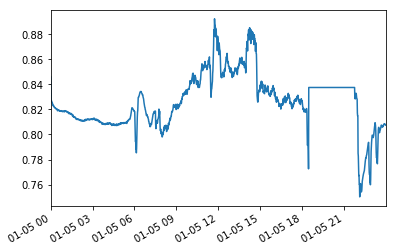

In [7]:
df["2017-01-05":"2017-01-05"].cwshdr.plot()

In [61]:
# take a sample
data = df[ ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr", "systotpower", "cwsfhdr"] ].dropna()
data = data["2017-01-01":"2017-01-06"]

# decompose.
# Alternative decompositions tried in other notebooks. Check them out.
# The central idea is that: The timeseries has 1-day periodicity. Taking Moving Average of 1*60*24 (1 day) and subtracting
# it from the original series would remove the intended patterns. 
#
# Note: Given the dity way continuous zeros have been removed, looks like we need to tweak
# this decompose method a bit and adapt to our scenario.. doesn't look correct to tweak. If I don't it seem to
# get in the way of trend.
df_decomposed = pd.DataFrame()
for col in data.columns:
    resp = sm.tsa.seasonal_decompose(data[col], freq=1*30*24)
    for part in ("seasonal", "trend", "resid"):
        col_name = "{0}_{1}".format(col, part)
        df_decomposed[col_name] = getattr(resp, part)

# first and last of df contains null.
df_decomposed = df_decomposed.dropna()

None


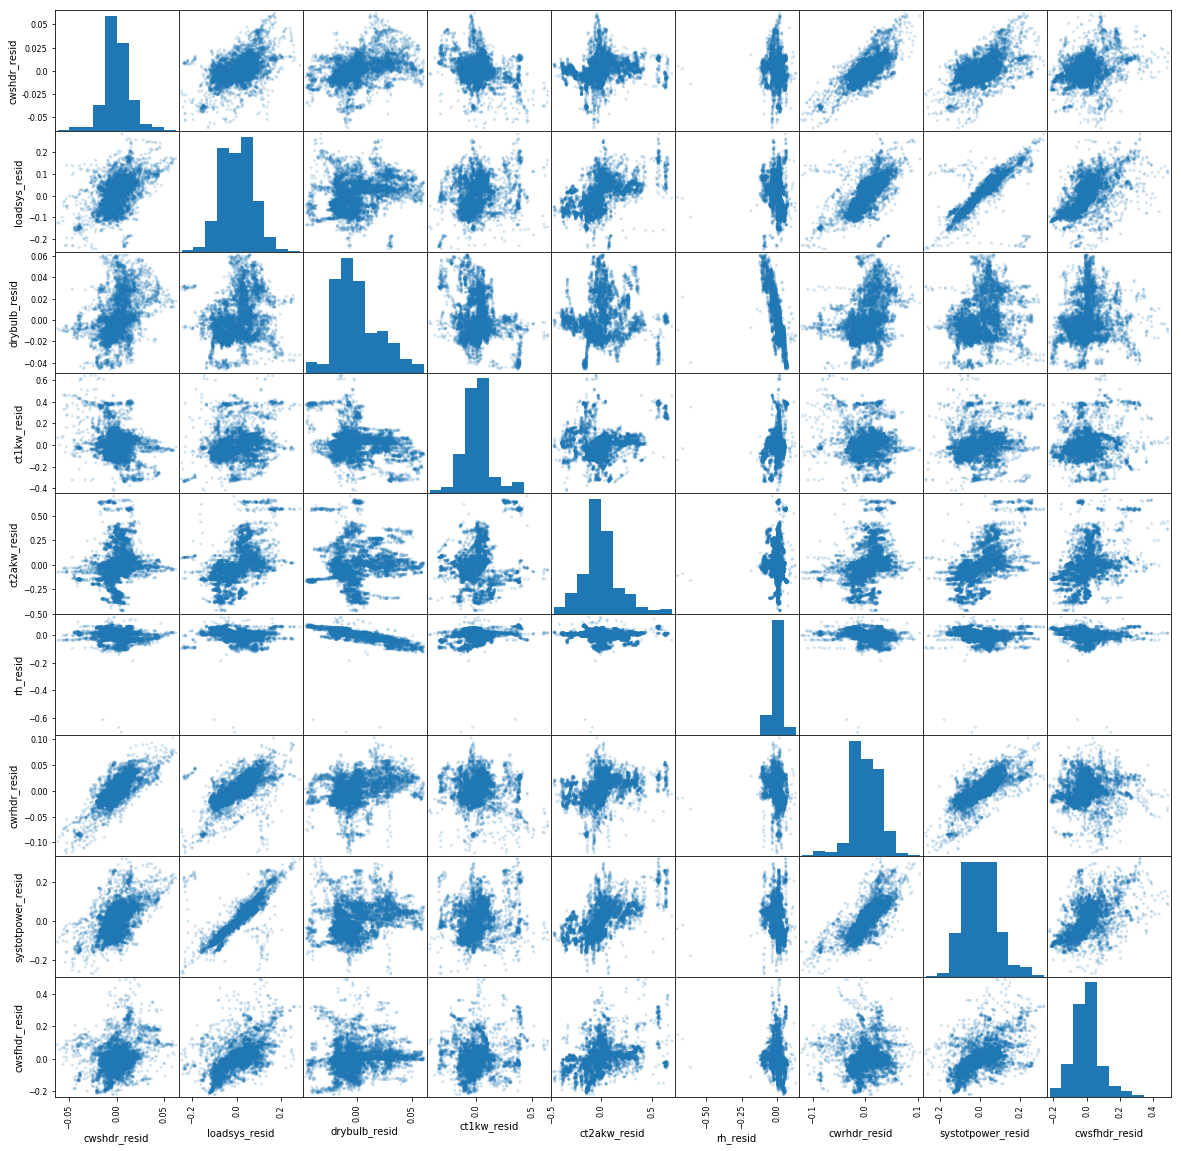

In [62]:
# Let's look at relationships -- a bird eye's view
plot_cols = ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr", "systotpower", "cwsfhdr"]
plot_part = "resid"

data_decomposed = df_decomposed[[i + "_" + plot_part for i in plot_cols]]
pd.plotting.scatter_matrix(data_decomposed, alpha=0.2, figsize=(20,20))
print(None)

In [15]:
df_decomposed.to_csv("../output/decomposed.csv")

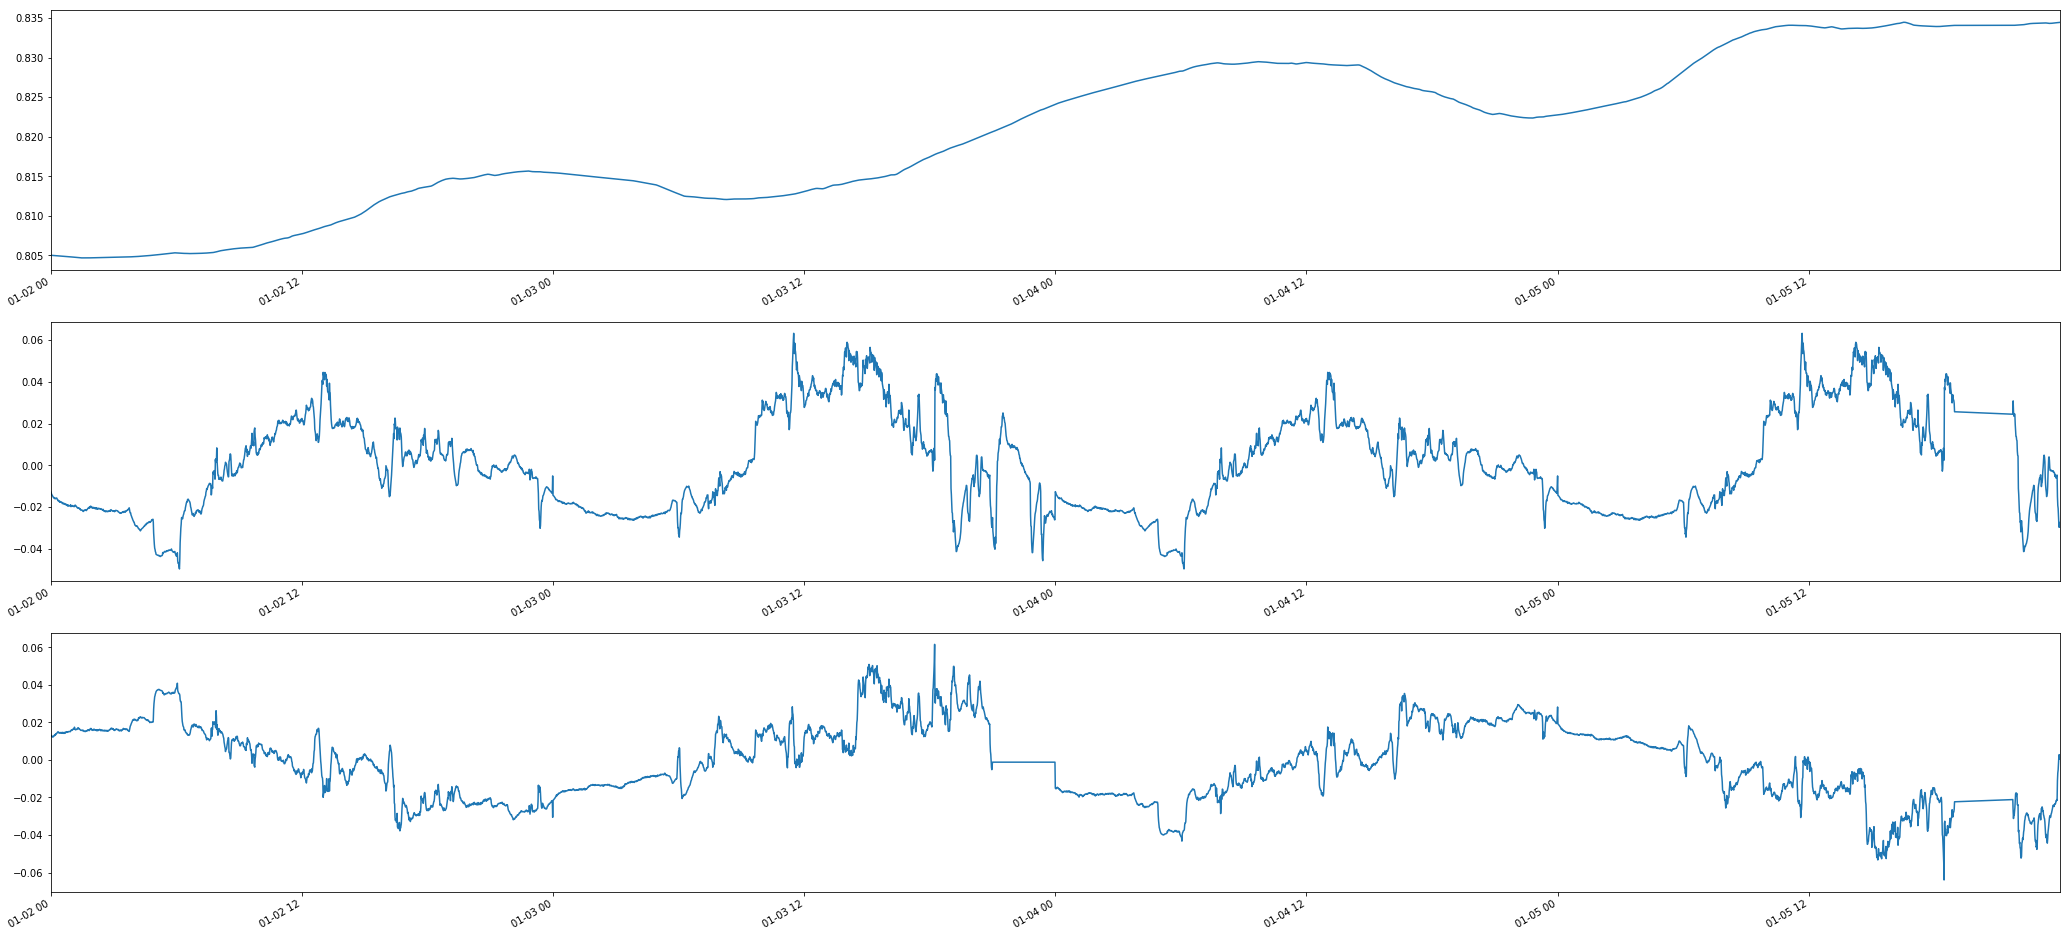

In [58]:
fig, a = plt.subplots(3,1,figsize=(36,6*3))
df_decomposed.cwshdr_trend.plot(ax=a[0])
df_decomposed.cwshdr_seasonal.plot(ax=a[1])
df_decomposed.cwshdr_resid.plot(ax=a[2])

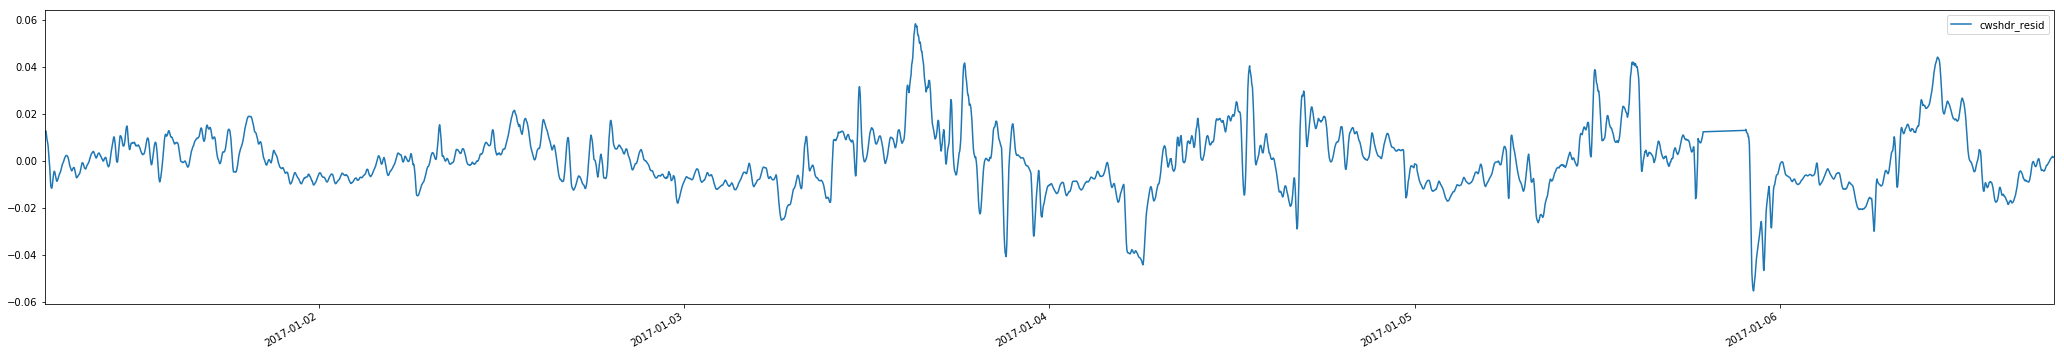

In [53]:
fig, ax = plt.subplots(1,1,figsize=(36,6))
df_decomposed[ ["cwshdr_resid",] ].rolling(10, min_periods=1).mean().plot(ax=ax)